# モネの白内障シミュレーション

- conda create -n colour_py36 python=3.6
- conda activate colour_py36
- conda install -c anaconda pip
- conda install -c anaconda jupyter
- conda install -c conda-forge jupyter_contrib_nbextensions
- conda install -c conda-forge colour-science
- conda install -c anaconda scipy 
- conda install -c conda-forge imageio
- conda install -c anaconda scikit-learn
- conda install -c anaconda scikit-image

- conda install freetype --force-reinstall
- conda install -c anaconda ipykernel 
- ipython kernel install --user --name colour_py36

- conda install -c conda-forge jupyter_nbextensions_configurator


## 画像を読み込む

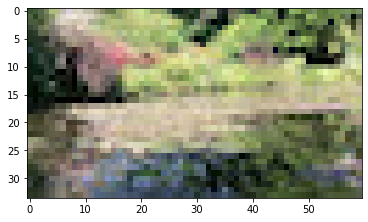

In [1]:
import numpy as np
from imageio.v3 import imread, imwrite
import matplotlib.pyplot as plt

img = imread('sampless.jpg'); plt.imshow(img)

## 輝度リニア画像に変換する

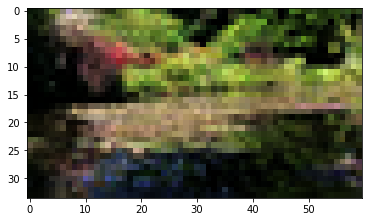

In [2]:
import skimage

# 1/2.2のγ補正を、逆数の2.2γ補正で除去し、輝度リニア画像に変換する
linear_img = skimage.exposure.adjust_gamma(img/255.0, 2.2)
plt.imshow(linear_img)

## 視力ボケ効果を入れる

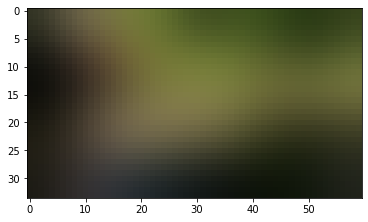

In [3]:
from scipy.ndimage import gaussian_filter

# 視力ボケ効果を入れる
blur_linear_img = gaussian_filter(linear_img, [5,5,0])
plt.imshow(blur_linear_img)

## 分光画像（もどき）にする

/Users/jun/opt/anaconda3/envs/colour/lib/python3.10/site-packages/colour/utilities/verbose.py:266: ColourUsageWarning: The "CIE 2012 2 Degree Standard Observer" has been renamed to "CIE 2015 2 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)
/Users/jun/opt/anaconda3/envs/colour/lib/python3.10/site-packages/colour/utilities/verbose.py:266: ColourUsageWarning: The "CIE 2012 10 Degree Standard Observer" has been renamed to "CIE 2015 10 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)


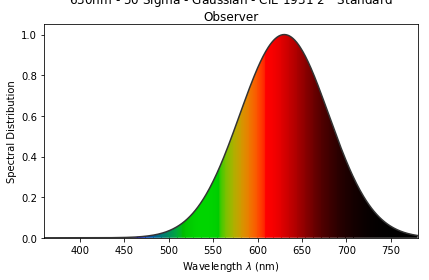

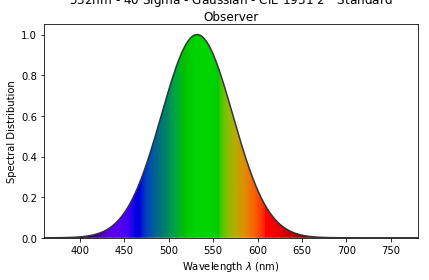

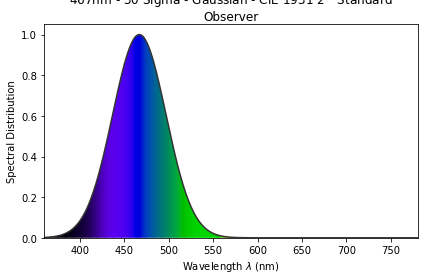

In [4]:
import colour

# 赤 630 nm，緑 532 nm，青467 nm
r = colour.sd_gaussian(630, 50)
g = colour.sd_gaussian(532, 40)
b = colour.sd_gaussian(467, 30)

colour.plotting.plot_single_sd(r)
colour.plotting.plot_single_sd(g)
colour.plotting.plot_single_sd(b)

# rgb値（値域は各0-1）から分光情報を作る関数
def rgb2sd(rgb, r, g, b):
    return r*rgb[0] + g*rgb[1] + b*rgb[2]

In [5]:
#rgb画像を分光画像に変える
sd_img = [[rgb2sd(rgb,r,g,b) for rgb in row] for row in linear_img]
blur_sd_img = [[rgb2sd(rgb,r,g,b) for rgb in row] for row in blur_linear_img]

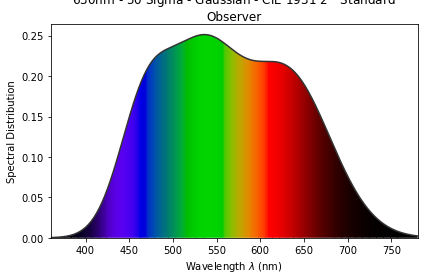

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'630nm - 50 Sigma - Gaussian - CIE 1931 2$^\\circ$ Standard Observer'}, xlabel='Wavelength $\\lambda$ (nm)', ylabel='Spectral Distribution'>)

In [6]:
# 試しに最初の画素の分光情報をを眺めてみる
colour.plotting.plot_single_sd(blur_sd_img[0][0])

## 分光値を変化させる重み関数を作る

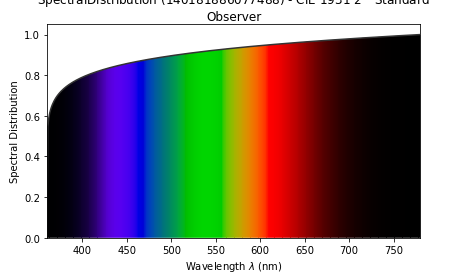

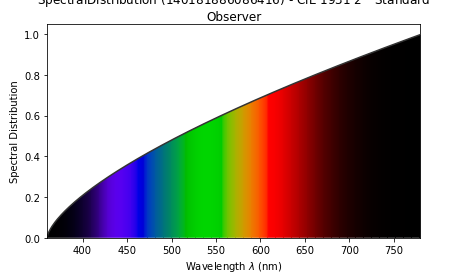

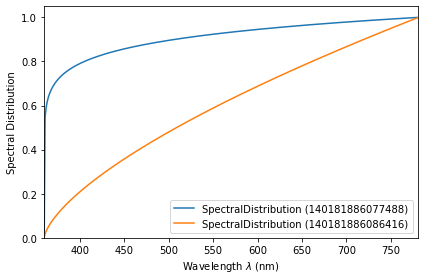

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Wavelength $\\lambda$ (nm)', ylabel='Spectral Distribution'>)

In [7]:
# 分光値を変化させる重み関数を作る
def transmittance(weight_gamma):
    sd_weight = {}
    for w in range(421): # 360 to 780
        sd_weight[360+w] = (w/421.0)**weight_gamma
    return colour.SpectralDistribution(sd_weight)

sd_weight0 = transmittance(1/10.)
sd_weight1 = transmittance(1/1.5)

colour.plotting.plot_single_sd(sd_weight0)
colour.plotting.plot_single_sd(sd_weight1)
colour.plotting.plot_multi_sds([sd_weight0,sd_weight1])

## 分光画像に透過率を適用する

In [8]:
sd_img = [[sd*sd_weight0 for sd in row] for row in sd_img]
blur_sd_img = [[sd*sd_weight1 for sd in row] for row in blur_sd_img]

## RGB画像に再変換する

In [9]:
# RGB画像再変換に使う視覚特性や照明条件
cmfs = colour.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"]
illuminant = colour.SDS_ILLUMINANTS["D65"]

def sd2rgb(sd):
    xyz = colour.sd_to_XYZ(sd, cmfs, illuminant)
    return colour.XYZ_to_sRGB(xyz)  

In [13]:
rgb_img0 = np.array([[sd2rgb(sd) for sd in row] for row in sd_img])
rgb_img1 = np.array([[sd2rgb(sd) for sd in row] for row in blur_sd_img])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


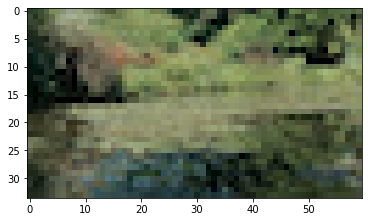

In [14]:
plt.imshow(rgb_img0/10)

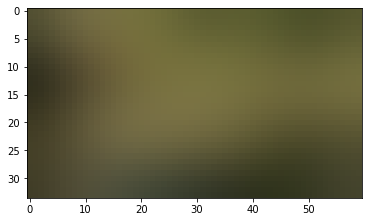

In [16]:
plt.imshow(rgb_img1/10)

## 処理した画像を保存する

In [23]:
imwrite('samples_0.png',np.clip(rgb_img0/10*255,0,255).astype('uint8'))
imwrite('samples_1.png',np.clip(rgb_img1/10*255,0,255).astype('uint8'))

In [ ]:
import numpy as np; import skimage; import colour
from imageio.v3 import imread, imwrite
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
# RGB画像を読み込み、画素値のγ補正を除去し、輝度相当にする
img = imread('sampless.jpg'); plt.imshow(img)
linear_img = skimage.exposure.adjust_gamma(img/255.0,2.2); plt.imshow(linear_img)
blur_linear_img = gaussian_filter(linear_img, [5,5,0]); plt.imshow(blur_linear_img)
# RGBに対してそれぞれ分光分布モドキを作り、RGB値から分光値に変える関数を作る
r = colour.sd_gaussian(630,50);colour.plotting.plot_single_sd(r)
g = colour.sd_gaussian(532,50);colour.plotting.plot_single_sd(g)
b = colour.sd_gaussian(467,50);colour.plotting.plot_single_sd(b)
def rgb2sd(rgb, r, g, b): # rgb値（値域は各0-1）から分光情報を作る関数
    return r*rgb[0] + g*rgb[1] + b*rgb[2]
# 素の画像、ボケ画像を、それぞれ分光画像に変える
sd_img = [[rgb2sd(rgb,r,g,b) for rgb in row] for row in linear_img]
blur_sd_img = [[rgb2sd(rgb,r,g,b) for rgb in row] for row in blur_linear_img]
colour.plotting.plot_single_sd(blur_sd_img[0][0])
# 分光透過率関数を作る
def transmittance(weight_gamma):
    sd_weight = {}
    for w in range(421): # 360 to 780
        sd_weight[360+w] = (w/421.0)**weight_gamma
    return colour.SpectralDistribution(sd_weight)
# 白内障前後の分光透過率を作る
sd_weight0=transmittance(1/10.);colour.plotting.plot_single_sd(sd_weight0)
sd_weight1=transmittance(1/1.5);colour.plotting.plot_single_sd(sd_weight1)
# 白内障前後の分光画像に、それぞれの透過率を適用する
sd_img = [[sd*sd_weight0 for sd in row] for row in sd_img]
blur_sd_img = [[sd*sd_weight1 for sd in row] for row in blur_sd_img]
# RGB画像に再変換するために、視覚の色特性や照明条件を設定し、sRGB変換関数を作る
cmfs = colour.MSDS_CMFS["CIE 1931 2 Degree Standard Observer"]
illuminant = colour.SDS_ILLUMINANTS["D65"]
def sd2rgb(sd):
    xyz = colour.sd_to_XYZ(sd, cmfs, illuminant)
    return colour.XYZ_to_sRGB(xyz)  
ralDistribution(sd_weight)
# 白内障前後の分光画像をsRGBに変換する
rgb_img0 = np.array([[sd2rgb(sd) for sd in row] for row in sd_img])
rgb_img1 = np.array([[sd2rgb(sd) for sd in row] for row in blur_sd_img])
# 画像表示やファイル保存のためのコード例
plt.imshow(rgb_img0/10)
plt.imshow(rgb_img1/10)
imwrite('samples_0.png',np.clip(rgb_img0/10*255,0,255).astype('uint8'))
imwrite('samples_1.png',np.clip(rgb_img1/10*255,0,255).astype('uint8'))

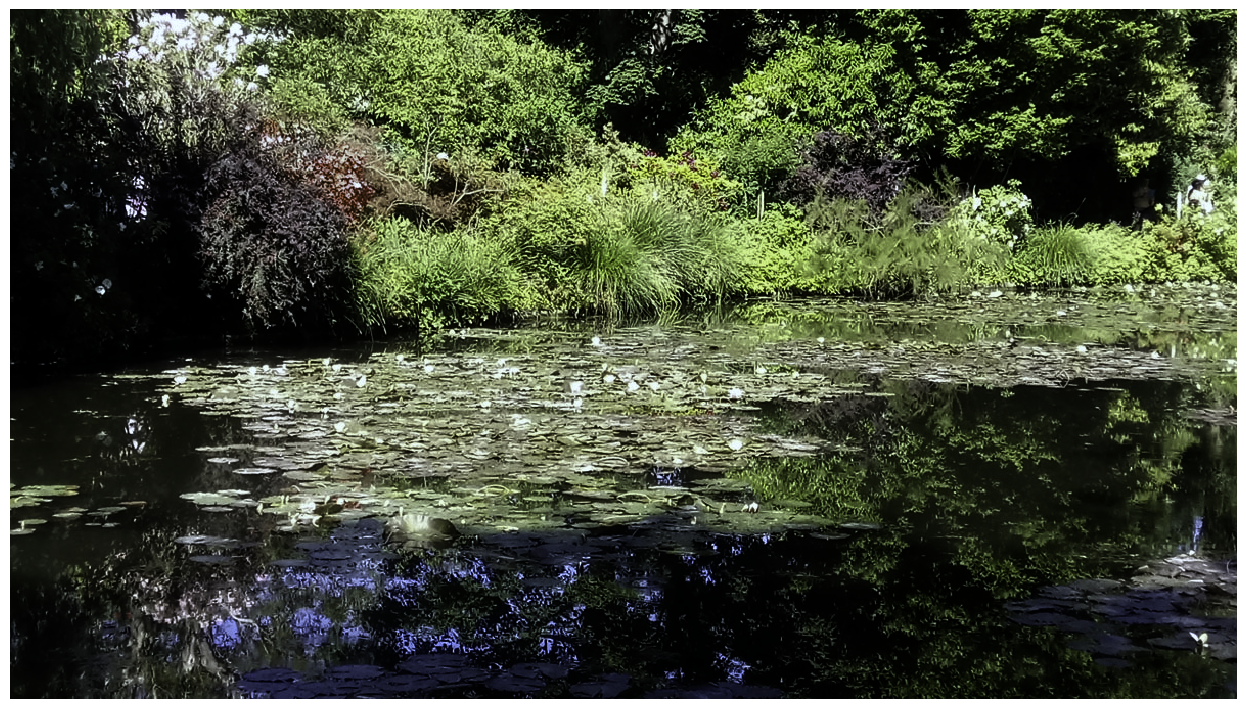

(<Figure size 1280x720 with 1 Axes>, <AxesSubplot:>)

In [24]:
import colour

XYZ = colour.sRGB_to_XYZ(img/255)
colour.plotting.plot_image(XYZ)